In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../Dades/diabetes/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# Inicialitzar el diccinari on hi hauran les funcions de likelihoods. Una per cada columna/variable.
likelihoods = {
    col: {
        'sa': None,
        'malalt': None
    } for col in list(df.columns)[:-1]
}
likelihoods

{'Pregnancies': {'sa': None, 'malalt': None},
 'Glucose': {'sa': None, 'malalt': None},
 'BloodPressure': {'sa': None, 'malalt': None},
 'SkinThickness': {'sa': None, 'malalt': None},
 'Insulin': {'sa': None, 'malalt': None},
 'BMI': {'sa': None, 'malalt': None},
 'DiabetesPedigreeFunction': {'sa': None, 'malalt': None},
 'Age': {'sa': None, 'malalt': None}}

In [4]:
# Afegir etiqueta target amb el nom de si està sà o no
df['target'] = df.Outcome.map({0: 'sa', 1: 'malalt'})

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target
0,6,148,72,35,0,33.6,0.627,50,1,malalt
1,1,85,66,29,0,26.6,0.351,31,0,sa
2,8,183,64,0,0,23.3,0.672,32,1,malalt
3,1,89,66,23,94,28.1,0.167,21,0,sa
4,0,137,40,35,168,43.1,2.288,33,1,malalt


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Separar les dades de train/test 
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 52)

In [8]:
prior = X_train.target.value_counts(normalize = True)
prior

sa        0.651466
malalt    0.348534
Name: target, dtype: float64

In [9]:
# probabilitat d'estar malalt sense tenir amb compte els parametres és del 34%
prior_malalt = prior['malalt']
prior_malalt

0.3485342019543974

In [10]:
prior_sa = prior['sa']

In [11]:
# Crear la conditional distribution que és la funció likelyhood de cada parametre vs si és sa/malalt
from scipy.stats import gaussian_kde

In [12]:
# Emplenar diccionari amb les funcions: 
for key, value in likelihoods.items():
    likelihoods[key]['sa'] = gaussian_kde(X_train[key].loc[X_train.target == 'sa'], bw_method='scott')
    likelihoods[key]['malalt'] = gaussian_kde(X_train[key].loc[X_train.target == 'malalt'], bw_method = 'scott')     

likelihoods

{'Pregnancies': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a08b8410>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a08f0790>},
 'Glucose': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a091d950>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a0115d90>},
 'BloodPressure': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a0924250>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a0924950>},
 'SkinThickness': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a0924d50>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a0925050>},
 'Insulin': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a0924fd0>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a09252d0>},
 'BMI': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a0925350>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a0925550>},
 'DiabetesPedigreeFunction': {'sa': <scipy.stats._kde.gaussian_kde at 0x191a09255d0>,
  'malalt': <scipy.stats._kde.gaussian_kde at 0x191a0925850>},
 'Age': {'sa': <scipy.stats._kde.gaussian_kde a

In [13]:
def evaluate_post(row):
    post_sa = prior_sa
    post_malalt = prior_malalt
    
    for key, value in likelihoods.items():
        lkh_sa = likelihoods[key]['sa']
        lkh_malalt = likelihoods[key]['malalt']
        
        post_sa *= lkh_sa.evaluate(row[key])[0]
        post_malalt *= lkh_malalt.evaluate(row[key])[0]

    if post_sa > post_malalt:
        return 'sa'
    elif post_malalt > post_sa:
        return 'malalt'
    else: 
        return '??'

In [14]:
# Per els registres de test, evaluem cada parametre a les lkh_sa/malalt i multipliquem el resultat per la prior
# Corresponent. Al final ens quedem amb la prior més gran i serà el que té més probabilitats de ser.
X_test['predicted'] = df.apply(lambda row: evaluate_post(row), axis = 1)

In [15]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,target,predicted
40,3,180,64,25,70,34.0,0.271,26,0,sa,malalt
316,3,99,80,11,64,19.3,0.284,30,0,sa,sa
199,4,148,60,27,318,30.9,0.150,29,1,malalt,sa
473,7,136,90,0,0,29.9,0.210,50,0,sa,malalt
418,1,83,68,0,0,18.2,0.624,27,0,sa,sa


In [16]:
X_test[['target', 'predicted']].head(3)

,target,predicted
40,sa,malalt
316,sa,sa
199,malalt,sa


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_theme(context = 'notebook', style = "white", font_scale = 1.0)

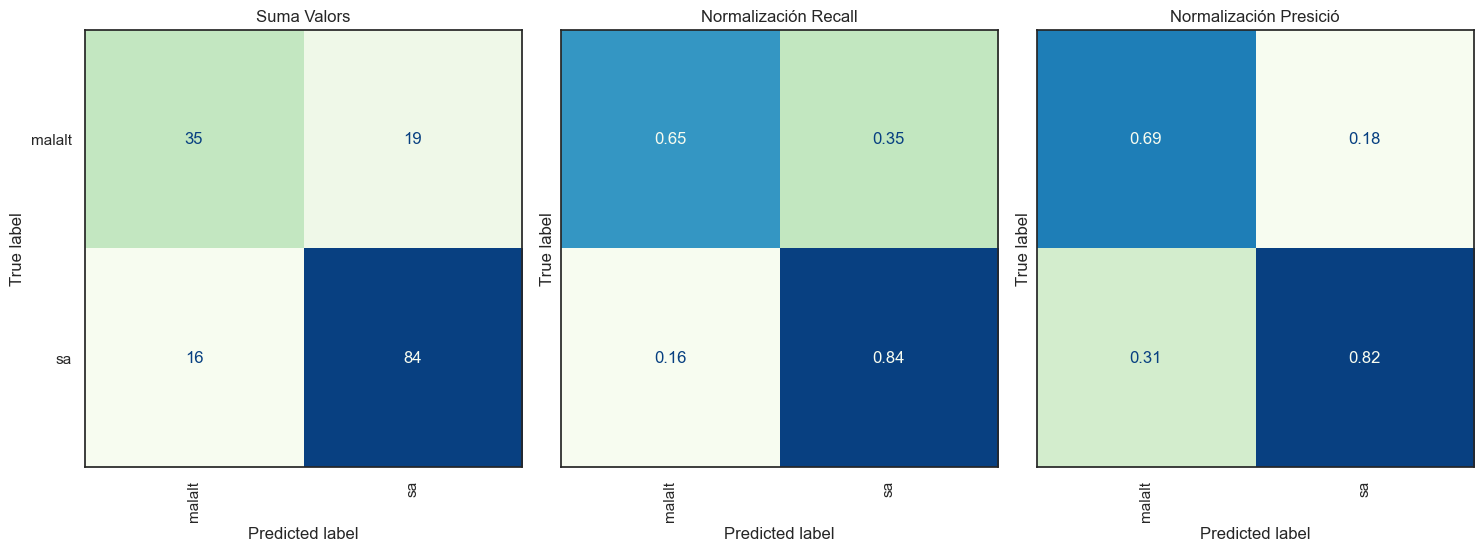

In [18]:
titles = ['Suma Valors', 'Normalización Recall', 'Normalización Presició']

_, axs = plt.subplots(1, 3, figsize = (15, 6), sharey = True)
for i, (norm, title) in enumerate(zip([None, 'true', 'pred'], titles)):
    # true: Normalització respecte true són els valors dividits pel total. Per la casella del la diagonal és el recall
    # pred: Normalització respecte els que hem predit (la vertical) a la diagonal la presició
    ConfusionMatrixDisplay.from_predictions(
        X_test.target,
        X_test.predicted,
        normalize = norm, # Posem aquesta informació aquí.
        values_format = '.2f' if norm is not None else '.0f',
        ax = axs[i],
        colorbar = False,
        cmap = 'GnBu',
        xticks_rotation = 90
    )
    axs[i].set_title(title)
plt.tight_layout();

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(X_test.target, X_test.predicted)

0.7727272727272727

In [20]:
from sklearn.metrics import precision_recall_fscore_support as prf
prf(X_test.target, X_test.predicted)
# presicion, recall, f_score, nºmostres

(array([0.68627451, 0.81553398]),
 array([0.64814815, 0.84      ]),
 array([0.66666667, 0.82758621]),
 array([ 54, 100], dtype=int64))

In [21]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prf(X_test.target, X_test.predicted, average = mode)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.750904,0.744074,0.747126
micro,0.772727,0.772727,0.772727
weighted,0.770209,0.772727,0.771160
